### Import

In [1]:
import joblib

# Preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from libs.raw_data import *
from libs.dataset import *
from architecture.architecture import *

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
is_test_mode = False
mode = "pre-train"
# mode = "fine_tuning"

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100 
MAX_SEQ_LEN = 200

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": ["detail_desc"]
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day", "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": ["detail_desc"]
}

# modality_info = {
#     "group": ["article_id", "sales_channel_id"],
#     "target": ["sales"],
#     "temporal": ["day", "dow", "month", "holiday", "price"],
#     "img": [],
#     "nlp": []
# }
# processing_info = {
#     "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
#     "embedding_cols": ["day", "dow", "month", "holiday"],
#     "img_cols": [],
#     "nlp_cols": []
# }

# Model
batch_size = 16
target_batch_size = 32
num_accm = int(target_batch_size//batch_size)
nhead = 4
dropout = 0.1
patch_size = 16

d_model = {"encoder":256, "decoder":128}
d_ff = {"encoder":256, "decoder":128}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"temporal":0.3, "img":0.3, "nlp":0.7}
# remain_rto = {"temporal":1., "img":1., "nlp":1.}

# Data

### Load data

In [3]:
data_info = DataInfo(modality_info, processing_info)
df_prep = get_raw_data(is_test_mode, is_prep_data_exist)

if mode == "pre-train":
    df_train = df_prep[(df_prep["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN)
                        &(df_prep["time_idx"] <= MAX_SEQ_LEN-1)
                        &(~pd.isna(df_prep["detail_desc"]))]

### Make dataset

In [4]:
if mode == "pre-train":
    train_dataset = Dataset(df_train, data_info, remain_rto)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
    joblib.dump(train_dataset.label_encoder_dict, "./src/label_encoder_dict.pkl")
    for data in train_dataloader:
        [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
        break

100%|██████████| 29274/29274 [00:01<00:00, 24337.37it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([16, 200, 1])
day torch.Size([16, 200])
dow torch.Size([16, 200])
month torch.Size([16, 200])
holiday torch.Size([16, 200])
price torch.Size([16, 200, 1])
target_fcst_mask torch.Size([16, 200])
temporal_padding_mask torch.Size([16, 200])
img_path torch.Size([16, 3, 224, 224])
detail_desc torch.Size([16, 55])
detail_desc_remain_idx torch.Size([16, 37])
detail_desc_masked_idx torch.Size([16, 17])
detail_desc_revert_idx torch.Size([16, 54])
detail_desc_remain_padding_mask torch.Size([16, 38])
detail_desc_masked_padding_mask torch.Size([16, 18])
detail_desc_revert_padding_mask torch.Size([16, 55])


# Pre-train

In [5]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def patchify(imgs, patch_size=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size=16):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs


def get_loss(output_dict, data_dict, data, idx_dict, padding_mask_dict, col_info, data_info, device):
    loss_dict = {}
    temporal_cols, img_cols, nlp_cols = col_info
    
    for n, ((key, pred), (key_, y)) in enumerate(zip(output_dict.items(), data_dict.items())):
        assert key == key_
        y = data[key].to(device)

        # Temporal loss
        if key in temporal_cols:
            ### Compute loss
            if key in data_info.processing_info["scaling_cols"]:
                loss = mse_loss(pred, y).squeeze()
            elif key in data_info.processing_info["embedding_cols"]:
                loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1).to(torch.long))
                loss = loss.view(y.shape)
            ### Apply mask
            padding_mask = padding_mask_dict["temporal_padding_mask"]
            masked_idx = idx_dict["temporal_block_masked_idx"]
            masking_mask = (masked_idx==n).sum(dim=-1)
            total_mask = torch.where((padding_mask==1) & (masking_mask==1), 1, 0)
            loss *= total_mask
            loss = loss.sum() / total_mask.sum()

        # Img loss
        elif key in img_cols:
            ### Compute loss
            pred = pred[:, 1:, :]
            # pred = patchify(pred, patch_size)
            y = patchify(data["img_path"].to(device), patch_size)
            loss = mse_loss(pred, y)
            ### Apply mask
            masked_idx = idx_dict[f"{key}_masked_idx"]
            masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, loss.shape[-1])
            loss = torch.gather(loss, index=masked_idx, dim=1)
            loss = loss.mean()

        ### Nlp loss
        elif key in nlp_cols:
            ### Compute loss
            pred = pred[:, 1:, :]
            y = y[:, 1:]
            loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1).to(torch.long))
            loss = loss.view(y.shape)
            ### Apply mask
            masked_idx = idx_dict[f"{key}_masked_idx"]
            masked_loss = torch.gather(loss, index=masked_idx, dim=1)

            padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"][:, 1:]

            loss = masked_loss * padding_mask
            loss = loss.sum() / padding_mask.sum()
        
        loss_dict[key] = loss
    
    return loss_dict


def obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict):
    loss_li_dict["total"].append(total_loss.item())
    mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())

    for key, val in loss_dict.items():
        loss_li_dict[key].append(val.item())
        mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())

    return loss_li_dict, mean_loss_li_dict

def plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size):
    plot_idx = 1
    for key, val in mean_loss_li_dict.items():
        # Individual loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(val)
        plt.title(f"{key}: {mean_loss_li_dict[key][-1]}")
        plot_idx += 1

        # Sample
        temporal_cols, img_cols, nlp_cols = col_info
        ### Temporal
        if key in temporal_cols:
            pred, y = output_dict[key].squeeze(), data_dict[key].squeeze()
            if key in data_info.processing_info["embedding_cols"]: pred = torch.argmax(pred, dim=-1)
            
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(y[idx].detach().cpu())
            plt.plot(pred[idx].detach().cpu())
        ### Img
        elif key in img_cols:
            pred, y = output_dict[key], data_dict[key]
            pred = unpatchify(pred[:, 1:, :], patch_size).permute(0,2,3,1)
            # pred = pred.permute(0,2,3,1)
            y = y.permute(0,2,3,1)

            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data["img_path_raw"].permute(0,2,3,1)[idx])

            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(y[idx].detach().cpu())
            
            plt.subplot(nrows, ncols, plot_idx+2)
            plt.imshow(pred[idx].detach().cpu())
        
        plot_idx += 3

        
    plt.tight_layout()        
    plt.show()


def pre_train(e, data_loader, optimizer, model, data_info, patch_size):
    pbar = tqdm(data_loader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    accm_idx = 0

    for n, data in enumerate(pbar):
        accm_idx += 1
        optimizer.zero_grad()
        model.train()
        output_dict, data_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)

        col_info = model.define_col_modalities(data_info)
        loss_dict = get_loss(output_dict, data_dict, data, idx_dict, padding_mask_dict, col_info, data_info, device)
        total_loss = torch.stack(list(loss_dict.values())).sum()  / len(loss_dict)
        total_loss /= accm_idx
        total_loss.backward()
        
        if accm_idx == num_accm:
            optimizer.step()
            accm_idx = 0

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 10, 4, 0
            plt.figure(figsize=(15,15))
            clear_output(wait=True)
            
            loss_li_dict, mean_loss_li_dict = obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict)
            plot_loss_sample(nrows, ncols, idx, mean_loss_li_dict, output_dict, data_dict, data, col_info, patch_size)
        
    return mean_loss_li_dict["total"][-1]
1==1

True

In [6]:
    def apply_dict_flatten(data, mod, temporal_cols, img_cols, nlp_cols):
        # Temporal
        temporal_block = torch.stack([val for key, val in data.items() if key in temporal_cols], dim=-2)
        temporal_data = temporal_block.view(temporal_block.shape[0], -1 ,temporal_block.shape[-1])

        # Static
        if len(img_cols + nlp_cols):
            static_data = torch.cat([val for key, val in data.items() if key in img_cols + nlp_cols], dim=-2)
        else: static_data = torch.tensor([]).to(device)

        # Flatten and apply
        flatten_data = torch.cat([temporal_data, static_data], dim=-2)
        flatten_data = mod(flatten_data)
        
        # Undo flatten
        temporal_undo = flatten_data[:, :temporal_data.shape[1], :]
        temporal_undo_block = temporal_undo.view(temporal_block.shape)
        static_undo = flatten_data[:, temporal_data.shape[1]:, :]

        # Make result
        result_dict = {}
        for n, col in enumerate(temporal_cols):
            result_dict[col] = temporal_undo_block[:, :, n, :]
        
        idx = 0
        for col in img_cols:
            length = data[col].shape[1]
            result_dict[col] = static_undo[:, idx:idx+length, :]
            idx += length
        
        for col in nlp_cols:
            length = data[col].shape[1]
            result_dict[col] = static_undo[:, idx:idx+length, :]
            idx += length
        
        assert idx == static_undo.shape[1]
        return result_dict

    def apply_block_flatten(temporal_block, img_dict, nlp_dict, mod):
        flatten_data = temporal_block.reshape(temporal_block.shape[0], -1, temporal_block.shape[-1])
        for key, val in img_dict.items():
            flatten_data = torch.cat([flatten_data, val], dim=-2)
        for key, val in nlp_dict.items():
            flatten_data = torch.cat([flatten_data, val], dim=-2)
        flatten_data = mod(flatten_data)
        
        temporal_block = flatten_data[:, :temporal_block.shape[1]*temporal_block.shape[2]].view(temporal_block.shape)
        idx = temporal_block.shape[1]*temporal_block.shape[2]
        for key, val in img_dict.items():
            length = val.shape[1]
            img_dict[key] = flatten_data[:, idx:idx+length, :]
            idx += length
        
        for key, val in nlp_dict.items():
            length = val.shape[1]
            nlp_dict[key] = flatten_data[:, idx:idx+length, :]
            idx += length
        
        assert idx == flatten_data.shape[1]

        return temporal_block, img_dict, nlp_dict


In [7]:
class AddGlobalToken(torch.nn.Module):
    def __init__(self, data_info, temporal_cols, img_cols, nlp_cols, d_model):
        super().__init__()
        self.data_info, self.temporal_cols, self.img_cols, self.nlp_cols = data_info, temporal_cols, img_cols, nlp_cols
        self.global_token = torch.nn.Parameter(torch.rand(1, d_model))
    
    def forward(self, data_dict):
        target_data_shape = data_dict[self.data_info.modality_info["target"][0]].shape
        batch_size, seq_len, d_model = target_data_shape
        global_token_seq = self.global_token.unsqueeze(0).repeat(batch_size, seq_len, 1)
        data_dict["global"] = global_token_seq
        data_dict = {key:data_dict[key] for key in ["global"]+self.temporal_cols+self.img_cols+self.nlp_cols}

        return data_dict

In [8]:
class MBAEEncoder(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict, temporal_cols, img_cols, nlp_cols,
                    d_model, num_layers, nhead, d_ff, dropout, activation,
                    patch_size):
        super().__init__()
        self.data_info, self.temporal_cols, self.img_cols, self.nlp_cols = data_info, temporal_cols, img_cols, nlp_cols
        # 1. Embedding
        self.embedding = Embedding(self.data_info, label_encoder_dict, d_model, temporal_cols, img_cols, nlp_cols, patch_size)
        # 2. Embedding norm
        self.embedding_norm = torch.nn.LayerNorm(d_model)
        # 3. Global sequence
        self.add_global_token = AddGlobalToken(data_info, temporal_cols, img_cols, nlp_cols, d_model)
        # 4. Encoder positional encoding & Modality embedding
        self.posmod_emb = PosModEmb(d_model, dropout, ["global"]+temporal_cols, img_cols, nlp_cols)
        # 5. Remain masking
        self.remain_mask = Remain(["global"]+temporal_cols, img_cols, nlp_cols)
        # 6. Encoder
        self.encoder = Encoder(d_model, nhead, d_ff, dropout, activation, num_layers)
        # 7. Encoding norm
        self.encoding_norm = torch.nn.LayerNorm(d_model)
    
    def forward(self, data_input, remain_rto, device):
        data_dict, idx_dict, padding_mask_dict = self.to_gpu(data_input, device)
        # 1. Embedding
        embedding_dict = self.embedding(data_dict, padding_mask_dict, device)
        # 2. Embedding norm
        embedding_dict = apply_dict_flatten(data=embedding_dict, mod=self.embedding_norm, temporal_cols=self.temporal_cols, img_cols=self.img_cols, nlp_cols=self.nlp_cols)
        # 3. Global sequence
        embedding_dict = self.add_global_token(embedding_dict)
        # 4. Encoder positional encoding & Modality embedding
        posmod_emb_dict = self.posmod_emb(embedding_dict, device)
        # 5. Remain masking
        temporal_block_remain, img_remain_dict, nlp_remain_dict, idx_dict, padding_mask_dict = self.remain_mask(posmod_emb_dict, idx_dict, padding_mask_dict, remain_rto, device)
        # 6. Encoder
        temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict = self.encoder(temporal_block_remain, img_remain_dict, nlp_remain_dict, padding_mask_dict)
        # 7. Encoding norm
        temporal_block, img_dict, nlp_dict = apply_block_flatten(temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, mod=self.encoding_norm)

        return temporal_block, img_dict, nlp_dict, encoding_weight_dict, data_dict, idx_dict, padding_mask_dict
    
    def to_gpu(self, data_input, device):
        data_dict, idx_dict, padding_mask_dict = {}, {}, {}
        data_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"] + self.data_info.modality_info["img"] + self.data_info.modality_info["nlp"]
        for key, val in data_input.items():
            if key in data_cols:
                data_dict[key] = data_input[key].to(device)
            elif key.endswith("idx"):
                idx_dict[key] = data_input[key].to(device)
            elif key.endswith("mask"):
                padding_mask_dict[key] = data_input[key].to(device)
            
        return data_dict, idx_dict, padding_mask_dict

class MBAEDecoder(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict, temporal_cols, img_cols, nlp_cols,
                    d_model_, d_model, num_layers, nhead, d_ff, dropout, activation,
                    patch_size):
        super().__init__()
        self.data_info, self.temporal_cols, self.img_cols, self.nlp_cols = data_info, temporal_cols, img_cols, nlp_cols
        # 1. Decoder embed
        self.decoder_embed = torch.nn.Linear(d_model_, d_model)
        # 2. Revert
        self.revert = Revert(d_model, ["global"]+temporal_cols, img_cols, nlp_cols)
        # 3. Decoder positional encoding & Modality embedding
        self.posmod_emb = PosModEmb(d_model, dropout, ["global"]+temporal_cols, img_cols, nlp_cols)
        # 4. Decoder
        self.encoder = Encoder(d_model, nhead, d_ff, dropout, activation, num_layers)
        # 5. Decoding norm
        self.decoding_norm = torch.nn.LayerNorm(d_model)
        # 6. Output
        self.output = Output(data_info, d_model, nhead, d_ff, dropout, activation, num_layers, label_encoder_dict, temporal_cols, img_cols, nlp_cols, patch_size)
    
    def forward(self, temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict, idx_dict, padding_mask_dict):
        # 1. Decoder embed
        temporal_block, img_dict, nlp_dict = apply_block_flatten(temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, mod=self.decoder_embed)
        # 2. Revert
        revert_dict = self.revert(temporal_block, img_dict, nlp_dict, idx_dict, padding_mask_dict)
        # 3. Decoder positional encoding & Modality embedding
        posmod_emb_dict = self.posmod_emb(revert_dict, device)
        temporal_block, img_dict, nlp_dict = self.block_it(posmod_emb_dict)
        # 4. Decoder
        temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict = self.encoder(temporal_block, img_dict, nlp_dict, padding_mask_dict, mode="revert")
        # 5. Decoding norm
        temporal_block, img_dict, nlp_dict = apply_block_flatten(temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, mod=self.decoding_norm)
        decoding_dict = self.unblock_it(temporal_block, img_dict, nlp_dict)
        decoding_dict = {key:val for key, val in decoding_dict.items() if key != "global"}
        # 6. Output
        output_dict = self.output(decoding_dict, padding_mask_dict)
        return output_dict
    
    def block_it(self, data_dict):
        temporal_block = torch.stack([val for key, val in data_dict.items() if key in ["global"]+self.temporal_cols], dim=-2)
        img_dict = {key:val for key, val in data_dict.items() if key in self.img_cols}
        nlp_dict = {key:val for key, val in data_dict.items() if key in self.nlp_cols}

        return temporal_block, img_dict, nlp_dict

    def unblock_it(self, temporal_block, img_dict, nlp_dict):
        result_dict = {}
        for n, col in enumerate(["global"] + self.temporal_cols):
            result_dict[col] = temporal_block[:, :, n, :]
        result_dict.update(img_dict)
        result_dict.update(nlp_dict)

        return result_dict

1==1

True

In [9]:
class MaskedBlockAutoencoder(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                    d_model, num_layers, nhead, d_ff, dropout, activation,
                    patch_size):
        super().__init__()
        temporal_cols, img_cols, nlp_cols = self.define_col_modalities(data_info)
        self.mbae_encoder = MBAEEncoder(data_info, label_encoder_dict, 
                                        temporal_cols, img_cols, nlp_cols,
                                        d_model["encoder"], num_layers["encoder"], nhead, d_ff["encoder"], dropout, activation,
                                        patch_size)
        self.mbae_decoder = MBAEDecoder(data_info, label_encoder_dict, 
                                        temporal_cols, img_cols, nlp_cols,
                                        d_model["encoder"], d_model["encoder"], num_layers["encoder"], nhead, d_ff["encoder"], dropout, activation,
                                        patch_size)

    def forward(self, data_input, remain_rto, device):
        temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict, data_dict, idx_dict, padding_mask_dict = self.mbae_encoder(data_input, remain_rto, device)
        decoding_dict = self.mbae_decoder(temporal_encoding_block, img_encoding_dict, nlp_encoding_dict, encoding_weight_dict, idx_dict, padding_mask_dict)

        return decoding_dict, data_dict, idx_dict, padding_mask_dict

    def define_col_modalities(self, data_info):
        temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
        img_cols = data_info.modality_info["img"]
        nlp_cols = data_info.modality_info["nlp"]

        return temporal_cols, img_cols, nlp_cols


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


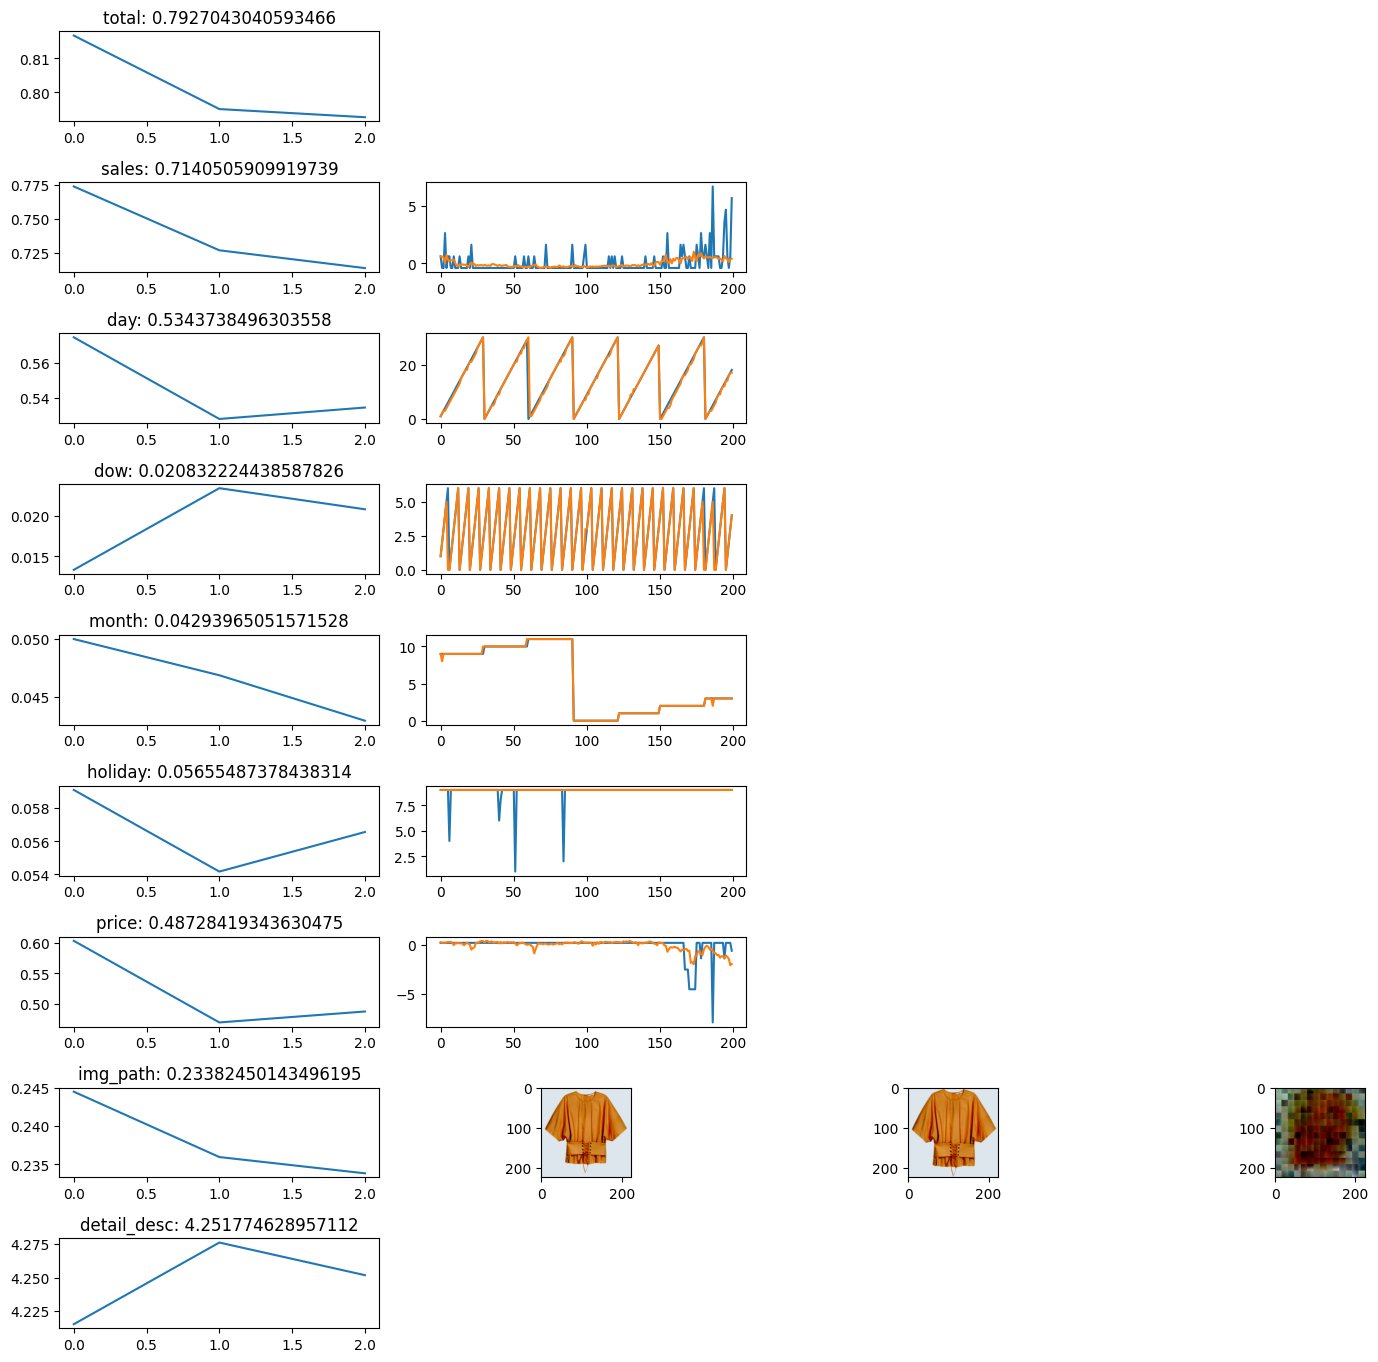

  3%|▎         | 49/1830 [00:13<05:28,  5.42it/s]

In [10]:
import datetime

if mode == "pre-train":
    # Define model
    label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")
    model = MaskedBlockAutoencoder(data_info, label_encoder_dict,
                            d_model, num_layers, nhead, d_ff, dropout, "gelu",
                            patch_size)
    model.to(device)
    summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

    # Train
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
    epoch = 3
    epoch_loss = {}
    
    for e in range(epoch):
        loss = pre_train(e, train_dataloader, optimizer, model, data_info, patch_size)
        scheduler.step()

        if not is_test_mode:
            now = datetime.datetime.now()
            path = f"./saved_model_epoch{e}_{now}"
            torch.save(model.state_dict(), path)
        epoch_loss[e] = loss

    print(epoch_loss)

In [ ]:
data["temporal_padding_mask"][2]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)

In [ ]:
torch.where(data["sales"]==0)

(tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9]),
 tensor([161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
         175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
         189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,   0,   3,  11,
          25,  30,  40,  45,  46,  51,  55,  68,  71,  78,  83,  84,  91,  96,
         103, 109, 111, 112, 137, 186, 187, 188, 189, 190, 191, 192, 193, 194,
         195, 196, 197, 198, 199, 127, 128, 129, 130, 131, 132, 133, 134, 135,
         136, 137

In [ ]:
data["sales[]"]